<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/new_structure/notebooks/Feature_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Part 0**
**Data preprocessing: generating a new dataset and a feature vector.**



In [2]:
!git clone https://github.com/Kat-ies/Coursework.git
%cd Coursework

Cloning into 'Coursework'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 50 (delta 7), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (50/50), done.
/content/Coursework


# Dataset WIDER_FACE

First of all, let's download the already marked-up dataset and prepare it for own dataset creating. 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


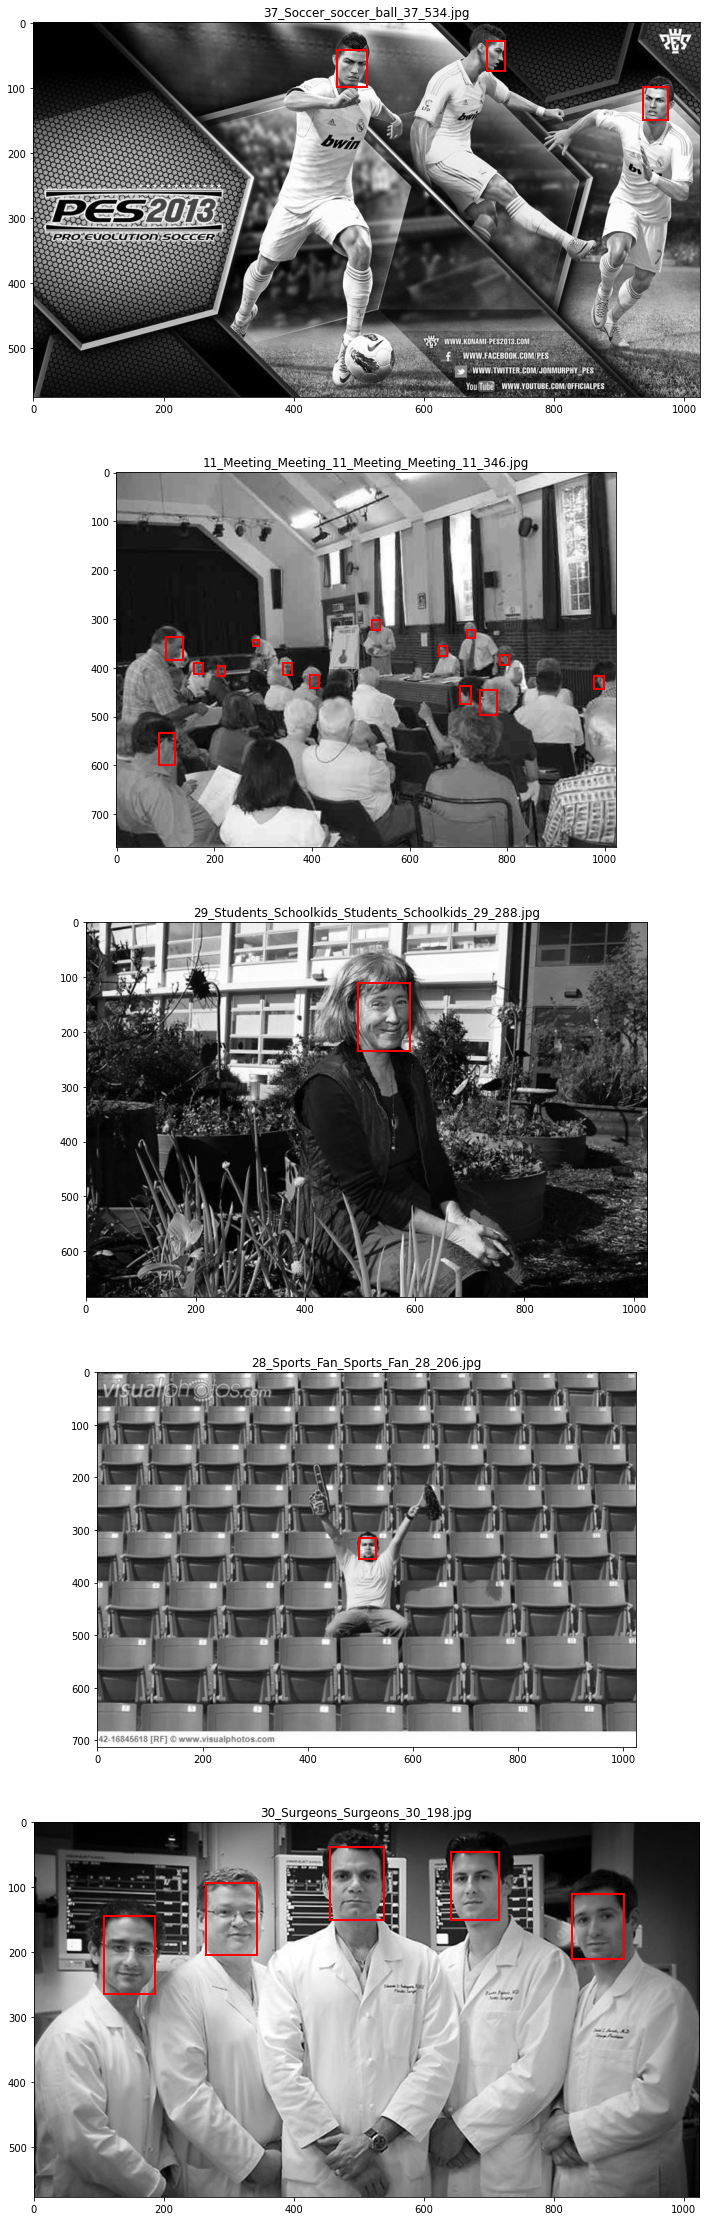

In [3]:
import images_and_frames as imf
from visualization import show_wider_face_dataset as show

%run zips_from_google-drive.py

images = imf.make_images_dict()
frames = imf.make_frames_dict(images)

show(images, frames)


#New dataset creation

The wider_face dataset is not suitable for the face classification task
to solve the classification problem, we want to input an image and tell: "Is the input image a face".   
So we will create new dataset.   
*All creation rules are mentioned in `new_dataset_creation.py`*



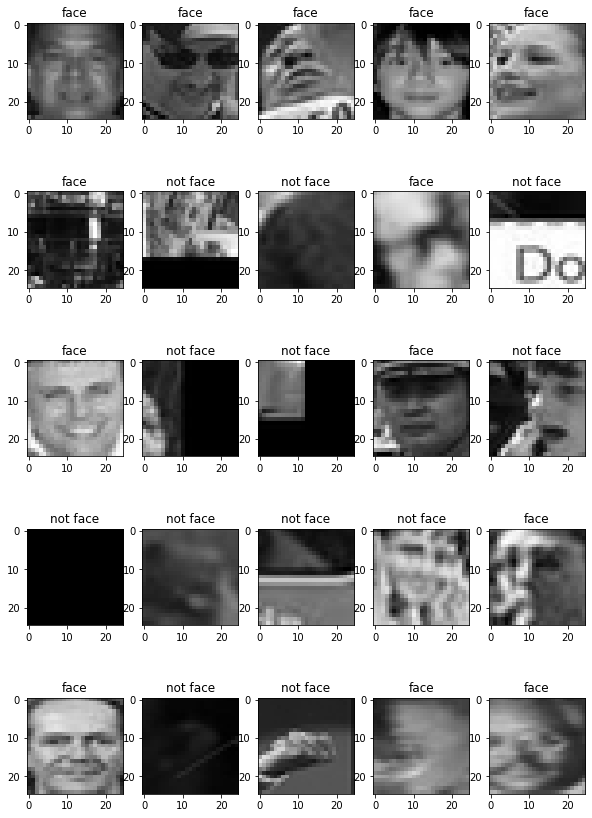

In [ ]:
from new_dataset_creation import ds_create
from visualization import show_faces_dataset as sh

faces_dataset = ds_create(images, frames)
sh(faces_dataset)

# Feature creation

There are a lot of ways to convert images into features for machine learning tasks.  
In this notebook will be used:
1. image matrix which is stretched into a one-dimensional vector
2.  (1) + pca method
3.  haars features  
*All rules and detailes are mentioned in `features.py`*


In [ ]:
from features import *

h_features = parse_file()
print(h_features[0].rect_list)

[HaarRect(x=6, y=4, w=12, h=9, weight=-1.0), HaarRect(x=6, y=7, w=12, h=3, weight=3.0)]


#Признаки Хоара

 Признаки я взяла из найденного раннее файла. Я скопировала n-строк, и там оказалось 109 признаков. 

 Формат хранения:
```
<features>  
  <_>
        <rects>
          <_>
            6 4 12 9 -1.</_>
          <_>
            6 7 12 3 3.</_></rects></_>
</features>
```
Представленный выше фрагмент описывает 1 признак Хоара, где прямоугольники задаются так:  
`<_> x1, y1, w, h, weight </_> `  
(верхний левый угол + ширина + высота + вес)  
  
более детальную информацию можно найти здесь:)  
https://api-2d3d-cad.com/viola-jones-method/

In [ ]:
class HaarFeature:

    def __init__(self, rect_list):
        self.rect_list = rect_list

    def cacl_feature(self, cumsum_marix):
        f_X = 0
        for rects in self.rect_list:
            if ((rects.w, rects.h) >= MAXSIZE):
                continue
            else:
                f_X += (cumsum_marix[rects.y - 1 + rects.h][rects.x - 1 + rects.w]
                        - cumsum_marix[rects.y - 1][rects.x - 1 + rects.w]
                        - cumsum_marix[rects.y - 1 + rects.h][rects.x - 1]
                        + cumsum_marix[rects.y - 1][rects.x - 1])*rects.weight
        return f_X

In [ ]:
# займёмся признаками Хоара
from lxml import etree

PATH = '/content/drive/My Drive/КУ Курсачи/Курсовой проект 2020/files/'   

h_features = []
HaarRect = namedtuple('HaarRect', 'x y w h weight')

# загрузим xml и распарсим его
with open(os.path.join(PATH, 'my_features.xml')) as fobj:
    xml = fobj.read()
    root = etree.fromstring(xml)

    for elems in root.getchildren():
        for rects in elems.getchildren():
            rectangles = []
            for haar_rect in rects.getchildren():
                numbers = haar_rect.text[11:].split(" ")
                rectangles.append(HaarRect(int(numbers[0]), int(numbers[1]), int(
                    numbers[2]), int(numbers[3]), float(numbers[4])))

            h_features.append(HaarFeature(rectangles))
print(h_features[0].rect_list)

[HaarRect(x=6, y=4, w=12, h=9, weight=-1.0), HaarRect(x=6, y=7, w=12, h=3, weight=3.0)]


#Ищем фичи
В этом блоке формируется вектор признаков, который нам так нужен. Каким образом?  
Перемешаем наш массив картинок с лицами и без (на данный момент изображения идут примерно через один)
Далее бежим по новой выборке и для каждого изображения
переводим изображение в интегральное представление.

Один признак Хоара - это 2-3 прямоугольника. Я не знаю, стоит ли учитывать вес, тк в документации https://madebyollin.github.io/opencv-python-docs/#CascadeClassifier-detectMultiScale я нашла конструктор, который использую я. Но там нет ничего про вес. Однако есть конструктор с весами. Только вот я не поняла, там речь идёт про веса прямоугольников или про веса, так называемые sum_stage, которые являются значениями признаков и используются в каскадных классификаторах, чтобы проверять, прошли ли мы порог данного уровня или нет.  
Но при этом есть прямоугольники с положительными весами и с отрицательными, и я так понимаю, это что-то вроде градации на чёрное и белое (тк там где области накладываются, мы суммируем веса, а цвет опред.знаком). Если вес убрать, то нужно искать области, где прямоугольники накладываются друг на друга, поэтому я пока оставила всё с весами и просто суммирую все значения в рамках одного признака, умножив их на соответствующий вес.

In [ ]:
# перемешаем выборку, подговим массив ответов, а также поделим всё на train  test
import sklearn.model_selection as sk

random.seed(RANDOM_SEED)
random.shuffle(faces)

y = np.array(list(map(lambda x: int(x.is_face), faces)))
x_train, x_test, y_train, y_test = sk.train_test_split(faces, y, test_size=0.25, random_state=0)


print(x_test[0])

Faces(img=<PIL.Image.Image image mode=L size=25x25 at 0x7F3DAD7CD978>, is_face=0, filename='41_Swimming_Swimming_41_917.jpg', rect=Rectangle(x=320, y=606, w=60, h=68))


In [ ]:
# подготовим изображения для получения признаков на нём и посчитаем признаки
# формируем вектор признаков

def feature_creating(sample, feature_type):
    features = []
    
    for images in sample:
        img = np.array(images.img, 'uint8')
        if feature_type != 'hf':
            features.append(img.flatten())
        else:
            # интегральное представление изображения
            matrix = np.cumsum(np.cumsum(img, axis=0), axis=1)
            f_for_one_img = []
            for fichi in h_features:
               f_for_one_img.append(fichi.cacl_feature(matrix))
            features.append(f_for_one_img)
    return np.array(features)

In [ ]:
#создаём признаки
import pandas as pd
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib 

samples = [x_train, x_test]
all_features = []

pca = PCA(n_components = len(h_features))
scaler = StandardScaler()

col_list = ['logreg_', 'tree_', 'knn_', 'svm_', 'randforest_', 'ada_boost_', 'grad_boost_']
categories = ['hf_train', 'mf_train','pca_train', 'hf_test', 'mf_test', 'pca_test']

time_df = pd.DataFrame(index = categories, columns = col_list)

for i, f_samples in enumerate(categories):
    parsed_str = f_samples.split("_")
    if  parsed_str[1] == 'train':
        index = 0
    else:
        index = 1
        
    t0 = time.time()
    all_features.append(feature_creating(samples[index], parsed_str[0]))
    t = time.time()
    time_df.loc[categories[i]] = (t - t0)/len(samples[index])

#сразу отмасштабируем полученные признаки
for i in range(0, len(all_features)//2 - 1):
    all_features[i] = scaler.fit_transform(all_features[i])
    all_features[i + 3] = scaler.transform(all_features[i + 3])
all_features[2] = pca.fit_transform(all_features[2])
all_features[5] = pca.transform(all_features[5])

#сохраним нашу выборку, она нам ещё понадобится
joblib.dump(all_features, os.path.join(PATH,'all_features.pkl'))
joblib.dump(y_train, os.path.join(PATH,'y_train.pkl'))
joblib.dump(y_test, os.path.join(PATH,'y_test.pkl'))
joblib.dump(x_train, os.path.join(PATH,'x_train.pkl'))
joblib.dump(x_test, os.path.join(PATH,'x_test.pkl'))
print(len(all_features[0]))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ulong_scalars
  from ipykernel import kernelapp as app


70817


In [ ]:
#время на создание фичей нам ещё пригодится, поэтому давайте пока сохраним куда-нибудь одну колонку
time_of_features_creat = time_df[col_list[0]].values.tolist()
joblib.dump(time_of_features_creat, os.path.join(PATH,'time_of_features_creat.pkl'))
joblib.dump(time_df, os.path.join(PATH, 'Dataframes','time_df_part0.pkl'))
print(time_of_features_creat)

[0.001659625456990573, 1.4513953624897554e-05, 1.4534237906060085e-05, 0.0016377798775480045, 1.339478926225142e-05, 1.4316083253121807e-05]


In [ ]:
#время в cек после создания признаков
time_df[:]

,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_
hf_train,0.00165963,0.00165963,0.00165963,0.00165963,0.00165963,0.00165963,0.00165963
mf_train,1.4514e-05,1.4514e-05,1.4514e-05,1.4514e-05,1.4514e-05,1.4514e-05,1.4514e-05
pca_train,1.45342e-05,1.45342e-05,1.45342e-05,1.45342e-05,1.45342e-05,1.45342e-05,1.45342e-05
hf_test,0.00163778,0.00163778,0.00163778,0.00163778,0.00163778,0.00163778,0.00163778
mf_test,1.33948e-05,1.33948e-05,1.33948e-05,1.33948e-05,1.33948e-05,1.33948e-05,1.33948e-05
pca_test,1.43161e-05,1.43161e-05,1.43161e-05,1.43161e-05,1.43161e-05,1.43161e-05,1.43161e-05
